# Unbalanced Cell Type Alignment

### Preprocessing

We can begin by loading in our data:

In [38]:
import pandas as pd
import scanpy as sc
import itertools
import anndata
import itertools
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from sklearn.preprocessing import normalize
from itertools import product
import umap
from collections import Counter
from sklearn.decomposition import PCA
import gridot
import schema
from gridot.utils import *

In [39]:
labels = pd.read_csv("./data/labels_full.txt", index_col=0,sep = '\t')
labels

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,ingest_celltype_label,leiden_res_0.8,celltype,sample_id
AAACAGCCAAATATCC-1,2272,2271,4746.0,369.0,7.774969,NK cells,9,NK_cells,10x_pbmc
AAACAGCCAGGAACTG-1,3254,3253,7760.0,693.0,8.930412,CD14+ Monocytes,6,CD14+_Monocytes,10x_pbmc
AAACAGCCAGGCTTCG-1,1798,1793,3661.0,409.0,11.171811,CD14+ Monocytes,3,CD14+_Monocytes,10x_pbmc
AAACCAACACCTGCTC-1,1145,1142,2159.0,271.0,12.552108,B cells,7,B_cells,10x_pbmc
AAACCAACAGATTCAT-1,1495,1494,2909.0,293.0,10.072189,NK cells,9,NK_cells,10x_pbmc
...,...,...,...,...,...,...,...,...,...
TTTGTGGCATCCGTAA-1,1346,1343,2560.0,432.0,16.875000,B cells,7,B_cells,10x_pbmc
TTTGTGGCATTAGCCA-1,972,969,1746.0,191.0,10.939290,CD4 T cells,1,CD4_T_cells,10x_pbmc
TTTGTGGCATTGCGAC-1,2330,2330,4772.0,316.0,6.621961,NK cells,9,NK_cells,10x_pbmc
TTTGTGTTCCGCCTAT-1,1057,1056,1913.0,252.0,13.173027,CD4 T cells,0,CD4_T_cells,10x_pbmc


In [40]:
labels = labels['celltype'].str.replace(" ","_")
np.unique(labels)

array(['B_cells', 'CD14+_Monocytes', 'CD4_T_cells', 'CD8_T_cells',
       'Dendritic_cells', 'FCGR3A+_Monocytes', 'NK_cells'], dtype=object)

In [41]:
# PREPROCESSING RNA SEQ
rna_adata = sc.read_h5ad('./data/adata.h5ad')
# del rna_adata.uns
rna_adata

AnnData object with n_obs × n_vars = 2664 × 334
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'ingest_celltype_label', 'leiden_res_0.8', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'hvg', 'ingest_celltype_label_colors', 'leiden', 'leiden_res_0.8_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'rep'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [42]:
np.unique(rna_adata.obs['celltype'])

array(['B_cells', 'CD14+_Monocytes', 'CD4_T_cells', 'CD8_T_cells',
       'Dendritic_cells', 'FCGR3A+_Monocytes', 'NK_cells'], dtype=object)

In [43]:
rna_adata.var['features'] = rna_adata.var.index

In [44]:
from collections import Counter
Counter(rna_adata.obs['celltype'])

Counter({'CD4_T_cells': 1194,
         'CD14+_Monocytes': 758,
         'B_cells': 223,
         'CD8_T_cells': 208,
         'FCGR3A+_Monocytes': 118,
         'NK_cells': 110,
         'Dendritic_cells': 53})

In [45]:
rna_adata = rna_adata[~rna_adata.obs['celltype'].isna()]
# rna_adata.obs['celltype'] = rna_adata.obs['celltype'].replace('B_cells_1', 'B_cells')

Counter(rna_adata.obs['celltype'])

Counter({'CD4_T_cells': 1194,
         'CD14+_Monocytes': 758,
         'B_cells': 223,
         'CD8_T_cells': 208,
         'FCGR3A+_Monocytes': 118,
         'NK_cells': 110,
         'Dendritic_cells': 53})

In [46]:
x_matrix = rna_adata.obsm['X_pca']
x_matrix.shape

(2664, 50)

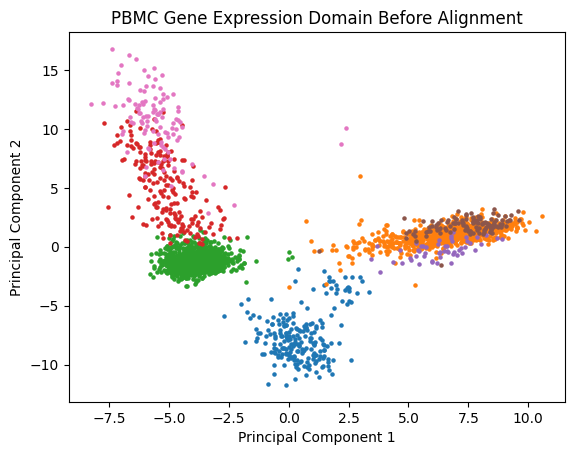

In [47]:
import numpy as np

# Sample label array (replace with your own label array)
label_array = np.array(rna_adata.obs['celltype'].to_list())

# Get unique labels
unique_labels = np.unique(label_array)
pca=PCA(n_components=2)
Xrna_2Dpca=pca.fit_transform(x_matrix)
# Plot PCA-transformed data with labels
plt.figure()

# Plot each unique label separately
for label in unique_labels:
    mask = (label_array == label)
    plt.scatter(Xrna_2Dpca[mask, 0], Xrna_2Dpca[mask, 1], s=5, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('PBMC Gene Expression Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [48]:
# import pycisTopic
import pickle
atac_raw = sc.read_h5ad('./data/atac_adata_raw_full.h5ad')
# atac_raw.obs['celltype'] = atac_raw.obs['celltype'].replace('B_cells_1', 'B_cells')
atac_raw

AnnData object with n_obs × n_vars = 2471 × 199446
    obs: 'celltype'
    var: 'Chromosome', 'Start', 'End'
    obsm: 'LDA'

In [49]:
atac_matrix = atac_raw.X
cell_name = atac_raw.obs
region_name = atac_raw.var

In [50]:
joint_list = list(set(cell_name.index ) & set(rna_adata.obs.index))


In [51]:
atac_lda = atac_raw.obsm['LDA']
atac_lda.shape

(2471, 50)

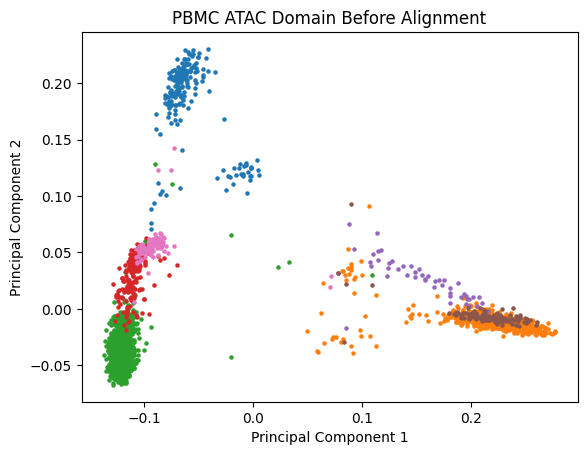

In [52]:
import numpy as np

# Sample label array (replace with your own label array)
label_array_atac = np.array(atac_raw.obs['celltype'].to_list())

# Get unique labels
unique_labels = np.unique(label_array_atac)
pca=PCA(n_components=2)
Yatac_2Dpca=pca.fit_transform(atac_lda)
# Plot PCA-transformed data with labels
plt.figure()

# Plot each unique label separately
for label in unique_labels:
    mask = (label_array_atac == label)
    plt.scatter(Yatac_2Dpca[mask, 0], Yatac_2Dpca[mask, 1], s=5, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('PBMC ATAC Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [53]:
Counter(label_array_atac)

Counter({'CD4_T_cells': 1125,
         'CD14+_Monocytes': 674,
         'B_cells': 211,
         'CD8_T_cells': 195,
         'FCGR3A+_Monocytes': 113,
         'NK_cells': 104,
         'Dendritic_cells': 49})

In [54]:
rna_adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,ingest_celltype_label,leiden_res_0.8,celltype
AAACAGCCAAATATCC-1,2272,2271,4746.0,369.0,7.774969,NK cells,9,NK_cells
AAACAGCCAGGAACTG-1,3254,3253,7760.0,693.0,8.930412,CD14+ Monocytes,6,CD14+_Monocytes
AAACAGCCAGGCTTCG-1,1798,1793,3661.0,409.0,11.171811,CD14+ Monocytes,3,CD14+_Monocytes
AAACCAACACCTGCTC-1,1145,1142,2159.0,271.0,12.552108,B cells,7,B_cells
AAACCAACAGATTCAT-1,1495,1494,2909.0,293.0,10.072189,NK cells,9,NK_cells
...,...,...,...,...,...,...,...,...
TTTGTGGCATCCGTAA-1,1346,1343,2560.0,432.0,16.875000,B cells,7,B_cells
TTTGTGGCATTAGCCA-1,972,969,1746.0,191.0,10.939290,CD4 T cells,1,CD4_T_cells
TTTGTGGCATTGCGAC-1,2330,2330,4772.0,316.0,6.621961,NK cells,9,NK_cells
TTTGTGTTCCGCCTAT-1,1057,1056,1913.0,252.0,13.173027,CD4 T cells,0,CD4_T_cells


In [55]:
import pickle
import scanpy as sc
rna = pd.DataFrame(x_matrix, index = rna_adata.obs.index)
atac = atac_lda
# adata = sc.read_h5ad('./data/PBMC/adata.h5ad')

We can name our data and look at its shape:

In [56]:
import pandas as pd
atac.columns = ["Region {0}".format(i + 1) for i in range(50)]
rna.columns = ["Gene {0}".format(i + 1) for i in range(50)]
rna.shape, atac.shape

((2664, 50), (2471, 50))

We can additionally look at the cell types present:

In [57]:
# attach celltype info to rna/atac data
rna['celltype'] = label_array
atac['celltype'] = label_array_atac

In [58]:
# retrieving numeric matrices
atac_mtx = atac.iloc[:, :-1]
rna_mtx = rna.iloc[:, :-1]

Note that we can easily view the manner in which we downsampled our data:

### Alignment

Now, we can begin our usual AGW workflow:

In [59]:
from scotplus.solvers import SinkhornSolver
from sklearn.preprocessing import normalize
import matplotlib.pylab as plt
from sklearn.decomposition import PCA

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


As usual, we normalize our data:

In [60]:
rna_mtx=normalize(rna_mtx)
atac_mtx=normalize(atac_mtx)

And visualize it in two dimensions before alignment:

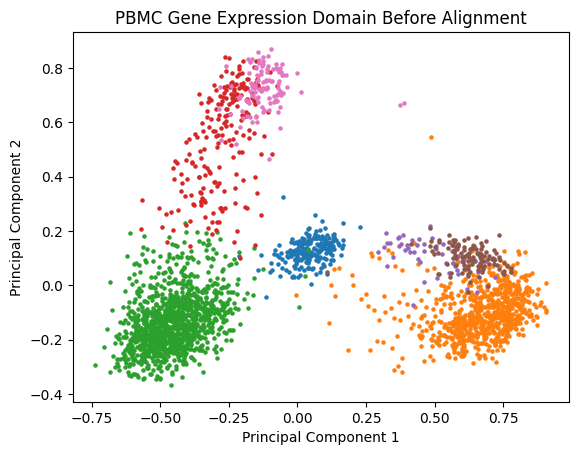

In [61]:
import numpy as np

label_array = np.array(rna['celltype'].to_list())

unique_labels = np.unique(label_array)
rna_pca = PCA(n_components=2)
rna_pca.fit(rna_mtx)
rna_2Dpca = rna_pca.transform(rna_mtx)
plt.figure()

for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(rna_2Dpca[subset, 0], rna_2Dpca[subset, 1], s=5, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('PBMC Gene Expression Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

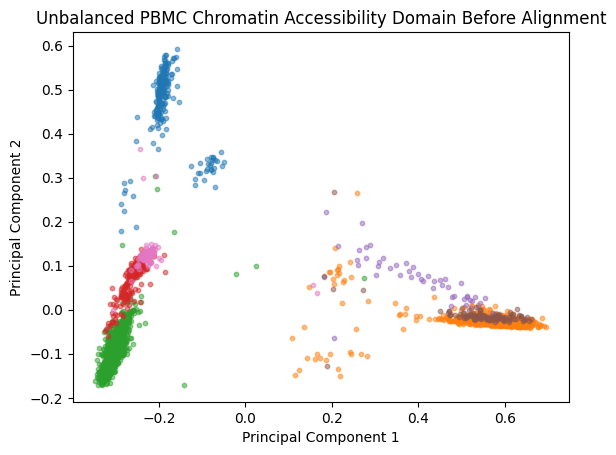

In [62]:
import numpy as np

label_array = np.array(atac['celltype'].to_list())

unique_labels = np.unique(label_array)
atac_pca=PCA(n_components=2)
atac_2Dpca=atac_pca.fit_transform(atac_mtx)
plt.figure()

for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(atac_2Dpca[subset, 0], atac_2Dpca[subset, 1], s=10, alpha=0.5, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('Unbalanced PBMC Chromatin Accessibility Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

We can now attempt an alignment:

In [63]:
from scotplus.utils.alignment import compute_graph_distances
from scotplus.utils.alignment import get_barycentre

D_rna = compute_graph_distances(rna_mtx, n_neighbors=110, mode='connectivity')
D_atac = compute_graph_distances(atac_mtx.astype('float32'), n_neighbors=110, mode='connectivity')

In [27]:
eps_values = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
best_eps = None
best_accuracy = -1
results = []

for eps in eps_values:
    print(f"\nTesting eps = {eps}")
    
    scot = SinkhornSolver(tol_uot=1e-6, nits_uot=500, nits_bcd=10, device=device)
    pi_samp, _, _ = scot.ugw(D_rna, D_atac, rho=(0.05, 0.05), eps=eps, verbose=False, device=device)
    
    aligned_rna = get_barycentre(torch.tensor(atac_mtx, dtype=torch.float32), pi_samp.cpu()).cpu()
    
    acc = transfer_accuracy(atac_mtx, aligned_rna, atac['celltype'], rna['celltype'], 5)
    results.append((eps, acc))
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_eps = eps

print("\n=== Hyperparameter tuning results ===")
for eps, acc in results:
    print(f"eps = {eps:.1e}, transfer accuracy = {acc:.4f}")

print(f"\nBest eps: {best_eps:.1e} with accuracy = {best_accuracy:.4f}")



Testing eps = 0.001

Testing eps = 0.0005

Testing eps = 0.0001

Testing eps = 5e-05

Testing eps = 1e-05

=== Hyperparameter tuning results ===
eps = 1.0e-03, transfer accuracy = 0.9114
eps = 5.0e-04, transfer accuracy = 0.8976
eps = 1.0e-04, transfer accuracy = 0.8794
eps = 5.0e-05, transfer accuracy = 0.8774
eps = 1.0e-05, transfer accuracy = 0.7070

Best eps: 1.0e-03 with accuracy = 0.9114


In [77]:
scot = SinkhornSolver(tol_uot=1e-6, nits_uot=500, nits_bcd=10,device = device)
pi_samp,_,pi_feat = scot.ugw(D_rna,D_atac, rho = (0.05, 0.05), eps = 1e-4, verbose = True,device = device) #RNA on to atac
aligned_rna = get_barycentre(torch.tensor(atac_mtx,dtype = torch.float32), (pi_samp.cpu())).cpu()



transfer_accuracy(atac_mtx,aligned_rna,atac['celltype'],rna['celltype'],5)

BCD Iteration 1 - Loss: 0.052235, 0.052490
BCD Iteration 2 - Loss: 0.035579, 0.036130
BCD Iteration 3 - Loss: 0.032867, 0.033561
BCD Iteration 4 - Loss: 0.032564, 0.033288
BCD Iteration 5 - Loss: 0.032375, 0.033106
BCD Iteration 6 - Loss: 0.032236, 0.032972
BCD Iteration 7 - Loss: 0.032166, 0.032908
BCD Iteration 8 - Loss: 0.032140, 0.032886
BCD Iteration 9 - Loss: 0.032127, 0.032875
BCD Iteration 10 - Loss: 0.032121, 0.032871


0.8794010522055847

In [78]:
pi_samp = pi_samp.cpu()
pi_samp.shape

torch.Size([2664, 2471])

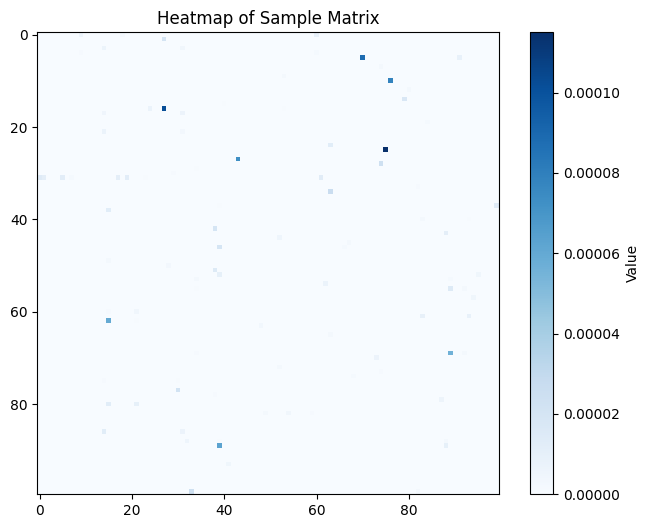

In [79]:
# plot a corner of the heatmap to get a sense for density
plt.figure(figsize=(8, 6))
plt.imshow(pi_samp[0:100,0:100].cpu(), cmap='Blues', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Heatmap of Sample Matrix')
plt.show()

Now, we can finally compute our alignment:

In [80]:
atac_mtx.shape, aligned_rna.shape

((2471, 50), torch.Size([2664, 50]))

### Evaluation

We can begin by visualizing the aligned data on its own, as well as in conjunction with the original RNAseq data:

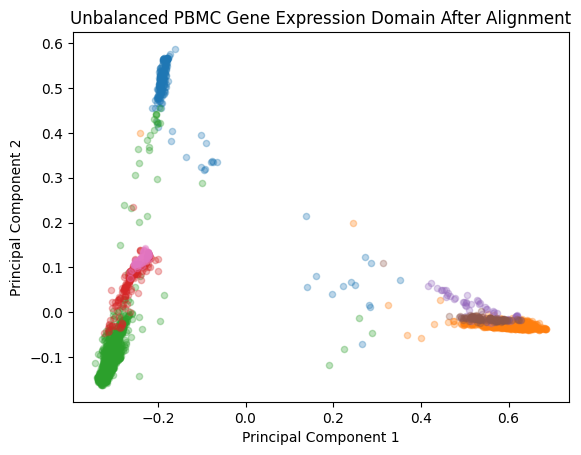

In [81]:
Xrna_integrated=atac_mtx
Yatac_subsamp_integrated=aligned_rna
concatenated=np.concatenate((Xrna_integrated,Yatac_subsamp_integrated), axis=0)

concatenated_pc=atac_pca.transform(concatenated)
Xrna_integrated_pc=concatenated_pc[0:Xrna_integrated.shape[0],:]
Yatac_subsamp_integrated_pc=concatenated_pc[Xrna_integrated.shape[0]:,:]

x_labels = np.array(label_array)
concat_labels = np.concatenate((x_labels,np.array(rna['celltype'])),axis=0)
concat_pc = np.concatenate((Xrna_integrated_pc,Yatac_subsamp_integrated_pc), axis=0)
for label in unique_labels:
    mask = (np.array(rna['celltype']) == label)
    plt.scatter(Yatac_subsamp_integrated_pc[mask, 0], Yatac_subsamp_integrated_pc[mask, 1], s=20, alpha=0.3, label = label)
    
    
plt.title('Unbalanced PBMC Gene Expression Domain After Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



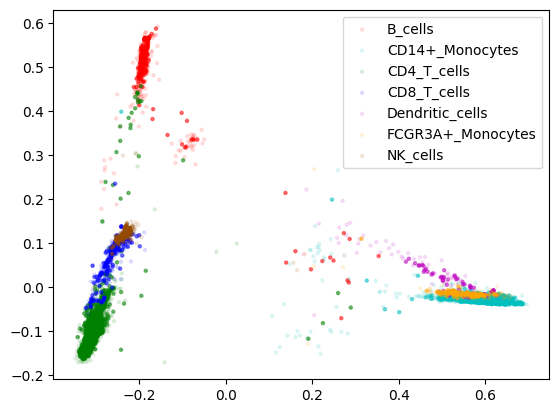

In [82]:
Xrna_integrated=atac_mtx
Yatac_subsamp_integrated=aligned_rna
concatenated=np.concatenate((Xrna_integrated,Yatac_subsamp_integrated), axis=0)

concatenated_pc=atac_pca.transform(concatenated)
Xrna_integrated_pc=concatenated_pc[0:Xrna_integrated.shape[0],:]
Yatac_subsamp_integrated_pc=concatenated_pc[Xrna_integrated.shape[0]:,:]

rna_labels = np.array(rna['celltype'])
x_labels = label_array
y_labels = rna_labels

alphas = (np.hstack((np.ones_like(x_labels, dtype=int)/10, np.ones_like(y_labels, dtype=int)/2)))

for (label, color) in zip(unique_labels, ['r', 'c', 'g', 'b', 'm', '#ffa500', '#964b00']):
    mask = (np.hstack((x_labels, y_labels)) == label)
    plt.scatter(np.vstack((Xrna_integrated_pc, Yatac_subsamp_integrated_pc))[mask, 0], np.vstack((Xrna_integrated_pc, Yatac_subsamp_integrated_pc))[mask, 1], s=5, label = label, c=color, alpha=alphas[mask])
plt.legend(loc='best', shadow=False)
plt.show()


In [83]:
atac_raw.X = csr_matrix(atac_raw.X)

In [92]:
atac_raw.X.todense().sum()

20961651

In [85]:
new_atac = pseudo_atac_generation(atac_raw.X,torch.tensor(pi_samp, dtype=torch.float32), 20,threshold = 0.2)


In [93]:

### preprocessing atac seq
atac_raw.var.index = atac_raw.var.index.astype(str)
atac_raw.var.columns = atac_raw.var.columns.astype(str)
projected_atac =  sc.AnnData(new_atac,
                      var = atac_raw.var,
                      obs = rna_adata.obs[['celltype']]
                      )
print(projected_atac)

sc.pp.filter_cells(projected_atac, min_genes=200) #filter out cells that express less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_genes(projected_atac, min_cells=3)
projected_atac.obs.columns = projected_atac.obs.columns.astype(str)
projected_atac.var.columns = projected_atac.var.columns.astype(str)
projected_atac.obs['orig.ident'] = projected_atac.obs.index
projected_atac.var['features'] = projected_atac.var.index


projected_atac.var[['chr_no', 'start','end']] = projected_atac.var['features'].str.split('-|:', expand=True)
projected_atac.var['start'] = projected_atac.var['start'].astype(str)
projected_atac.var['end'] = projected_atac.var['end'].astype(str)
projected_atac.var['Chromosome'] = projected_atac.var['chr_no']
projected_atac.var['chr_no'] = projected_atac.var['chr_no'].str.replace('chr', '')
projected_atac.var['Start'] = projected_atac.var['start']
projected_atac.var['End'] = projected_atac.var['end']


projected_atac.write_h5ad('./data/pseudo_atac_pbmc_binarized_20_20.h5ad')


AnnData object with n_obs × n_vars = 2664 × 199446
    obs: 'celltype'
    var: 'Chromosome', 'Start', 'End'


In [95]:
projected_atac.X.sum()

40089283